This is the code for Approach 2 mentioned in the project report.
We train an auxillary network to take LLaMA embeddings as input to play the game TicTacToe.
The MCTS part of the code is adopted from https://github.com/suragnair/alpha-zero-general
The checkpoint for the testing results showed in the paper is available upon request

In [1]:
!git lfs install
!git clone https://huggingface.co/tloen/alpaca-lora-7b

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
fatal: destination path 'alpaca-lora-7b' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/tloen/alpaca-lora.git

fatal: destination path 'alpaca-lora' already exists and is not an empty directory.


In [3]:
!pip install -r alpaca-lora/requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-yw8e4sa5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-yw8e4sa5
  Resolved https://github.com/huggingface/peft.git to commit 632997d1fb776c3cf05d8c2537ac9a98a7ce9435
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import torch

In [5]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf", device_map = "sequential")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [6]:
tokenizer.pad_token_id = (
    0  # unk. we want this to be different from the eos token
)
tokenizer.padding_side = "left"

In [7]:
ids = tokenizer(['   1 2 3 \n  A |X| |O|\n  B | |X|X|\n  C | | |O|\n', '   1 2 3 \n  A |O|X|O|\n  B |X|X| |\n  C |X|O| |\n', '   1 2 3 \n  A |O| |X|\n  B | |X| |\n  C | | | |\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A |O| | |\n  B | | | |\n  C |X| | |\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A | | |X|\n  B | |O| |\n  C | | | |\n', '   1 2 3 \n  A |O| |X|\n  B | |X| |\n  C | | | |\n', '   1 2 3 \n  A |X|X|O|\n  B |O|X|X|\n  C | | |O|\n', '   1 2 3 \n  A |X| |O|\n  B | |X|X|\n  C | | |O|\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A |X|O|X|\n  B | |O| |\n  C |O|X| |\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A |O| |X|\n  B |X|X| |\n  C |O| | |\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A | | | |\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A |O| | |\n  B | |O| |\n  C |X| |X|\n', '   1 2 3 \n  A | | | |\n  B | |X| |\n  C | | | |\n', '   1 2 3 \n  A | | | |\n  B | |X| |\n  C |X| |O|\n', '   1 2 3 \n  A | |X|X|\n  B | | | |\n  C | | |O|\n', '   1 2 3 \n  A |O|X|X|\n  B |X|X|O|\n  C |O| | |\n', '   1 2 3 \n  A |X| | |\n  B | |O| |\n  C | | | |\n', '   1 2 3 \n  A | | | |\n  B | |X| |\n  C | | | |\n', '   1 2 3 \n  A | | | |\n  B | |X| |\n  C | | | |\n', '   1 2 3 \n  A |X|X| |\n  B | | | |\n  C |O| | |\n', '   1 2 3 \n  A |X| |X|\n  B | |O| |\n  C | | |O|\n', '   1 2 3 \n  A |O|X|O|\n  B |X|X| |\n  C |X|O| |\n', '   1 2 3 \n  A | | |X|\n  B | | | |\n  C | | | |\n', '   1 2 3 \n  A |O|X|O|\n  B |X|X| |\n  C |X|O| |\n', '   1 2 3 \n  A | | | |\n  B | |X| |\n  C | | | |\n', '   1 2 3 \n  A |X| |X|\n  B | |O| |\n  C | | |O|\n'],return_tensors="pt", padding=True)

In [8]:
ids

{'input_ids': tensor([[    0,     0,     0,  ..., 29949, 29989,    13],
        [    0,   268, 29896,  ..., 29989,   891,    13],
        [    0,     0,     0,  ...,   891,   891,    13],
        ...,
        [    0,   268, 29896,  ..., 29989,   891,    13],
        [    0,     0,     0,  ...,   891,   891,    13],
        [    0,     0,     0,  ..., 29949, 29989,    13]]), 'attention_mask': tensor([[0, 0, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}

In [9]:
ids['input_ids']

tensor([[    0,     0,     0,  ..., 29949, 29989,    13],
        [    0,   268, 29896,  ..., 29989,   891,    13],
        [    0,     0,     0,  ...,   891,   891,    13],
        ...,
        [    0,   268, 29896,  ..., 29989,   891,    13],
        [    0,     0,     0,  ...,   891,   891,    13],
        [    0,     0,     0,  ..., 29949, 29989,    13]])

In [10]:
import sys
import torch
from peft import PeftModel
import transformers

from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
import bitsandbytes as bnb
load_8bit = True

model = LlamaForCausalLM.from_pretrained(
            'decapoda-research/llama-7b-hf',
            # load_in_8bit=load_8bit,
            # load_in_8bit_fp32_cpu_offload=True,
            offload_folder="content",
            torch_dtype=torch.float32,
            device_map="auto"
        )

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libcudart.so'), PosixPath('/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/ec2-user/anaconda3/envs/pytorch_p39/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [12]:
@torch.no_grad()
def get_output_embeddings(sentence):
    token = tokenizer(sentence,padding= True, return_tensors="pt")
    output = model(
        token['input_ids'],output_hidden_states=True
    )
    return output.hidden_states[-1][:,-1,:]

In [13]:
import numpy as np

In [16]:
# Generate embeddings given a list of instruction
def generate_embedding(instruction, input):
  if isinstance(input, list):
    output = []
    for item in input:
      output.append(f"""{item}""")
    return get_output_embeddings(output)
  # print(input)
  if input:
          output = f"""{input}"""
  else:
          output = f"""{input}"""

  return get_output_embeddings(output)

In [17]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [18]:
class FeedforwardNet(nn.Module):
    def __init__(self):
        super(FeedforwardNet, self).__init__()

        self.fc1 = nn.Linear(4096, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 10)
        self.fc6 = nn.Linear(512, 1)
        self.softmax_layer = nn.Softmax(dim=1)
        self.sigmoid_layer = nn.Sigmoid()

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.fc1(x)))
        x = nn.ReLU()(self.bn3(self.fc2(x)))
        x = nn.ReLU()(self.bn4(self.fc4(x)))
        action_probs = F.log_softmax(self.fc5(x),dim=-1)
        value = torch.tanh(self.fc6(x))
        
        return action_probs, value

In [19]:
def print_board(board_list):
  if board_list.ndim == 3:
    lst = []
    for board in board_list:
          board = board.reshape(3,3)
          n = board.shape[0]
          letters = ['A', 'B', 'C']
          string = '   '
          for y in range(n):
              string += f'{y+1} '
          string += '\n'

          for x in range(n):
              string += f'  {letters[x]} '
              string += '|'
              for y in range(n):
                  string += 'X' * int(board[x, y] == -1)
                  string += 'O' * int(board[x, y] == 1)
                  string += ' ' * int(board[x, y] == 0)
                  string += '|'
              string += '''\n'''
          lst.append(string)
  else:
        board = board_list.reshape(3,3)
        n = board.shape[0]
        letters = ['A', 'B', 'C']
        string = '   '
        for y in range(n):
            string += f'{y+1} '
        string += '\n'

        for x in range(n):
            string += f'  {letters[x]} '
            string += '|'
            for y in range(n):
                string += 'X' * int(board[x, y] == -1)
                string += 'O' * int(board[x, y] == 1)
                string += ' ' * int(board[x, y] == 0)
                string += '|'
            string += '''\n'''
        lst = string
  return lst

In [20]:
# log.info('Loading %s...', nn.__name__)
device = 'cuda'
nnet = FeedforwardNet().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
nnet.apply(init_weights)
optimizer = torch.optim.AdamW(nnet.parameters(),lr=0.003,eps=1e-4)

/tmp/ipykernel_15687/2454519674.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [21]:
scaler = torch.cuda.amp.GradScaler()

In [23]:
prompt = """I am the O player in a game tic-tac-toe, the other player is X and I'm supposed to play next. The board configuration is given in input. If I play optimally and the opponent play optimally, output the value (between -1 and 1, with 1 reprsenting me winning and -1 losing) and policy functions for the current configuration, no explanations."""

In [66]:
@torch.no_grad()
def predict(board):
    """
    board: np array with board
    """
    # timing
    start = time.time()

    # preparing input
    board = board.astype(np.float64)
    boardstr = print_board(board)
    emb = generate_embedding(prompt, boardstr)
    data = emb.to(device)
    data.requires_grad = True

    if args.cuda: data = data.contiguous().cuda()

    with torch.cuda.amp.autocast():
        nnet.eval()
        pi, v = nnet(data)
        
    alpha = 1.1
    alpha = 1.1
    sample_size = 10

      # Generate sample from Dirichlet distribution
    sample = np.random.dirichlet([alpha] * sample_size)

    # print(board)

    # print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
    return torch.exp(pi).data.cpu().numpy()[0]*0.85+sample*0.15, v.data.cpu().numpy()[0]

In [25]:
loss_hist = []
episode_count = []

In [26]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time

class dotdict(dict):
    def __getattr__(self, name):
        return self[name]
 
class AverageMeter(object):
    """From https://github.com/pytorch/examples/blob/master/imagenet/main.py"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def __repr__(self):
        return f'{self.avg:.2e}'

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

args = dotdict({
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 20,
    'batch_size': 20,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
})

device = 'cuda'

def loss_pi(targets, outputs):
    return -torch.sum(targets * outputs) / targets.size()[0]

def loss_v(targets, outputs):
    return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]


def train(examples):
    """
    examples: list of examples, each example is of form (board, pi, v)
    """
    optimizer.zero_grad()

    for epoch in range(args.epochs):
        print('EPOCH ::: ' + str(epoch + 1))
        pi_losses = AverageMeter()
        v_losses = AverageMeter()

        batch_count = int(len(examples) / args.batch_size)

        t = tqdm(range(batch_count), desc='Training Net')
        for step, _ in enumerate(t):
            sample_ids = np.random.randint(len(examples), size=args.batch_size)
            boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
            boards = np.array(boards).astype(np.float64)
            boardstr = print_board(boards) # (batchsize, )
            # print(boardstr,"nst")
            # print(np.shape(boardstr))
            emb = generate_embedding(prompt, boardstr).to(device)
            # print(emb.size(),"ccc")
            emb.requires_grad = True
            # print(emb, "embeddings")
            # compute output

            target_pis = torch.FloatTensor(np.array(pis)).to(device)
            target_vs = torch.FloatTensor(np.array(vs).astype(np.float64)).to(device)

            # # predict
            # if args.cuda:
            #     data, target_pis, target_vs = data.contiguous().cuda(), target_pis.contiguous().cuda(), target_vs.contiguous().cuda()
            with torch.cuda.amp.autocast():
              out_pi, out_v = nnet(emb)
      
              l_pi = loss_pi(target_pis, out_pi)
              l_v = loss_v(target_vs, out_v)

            total_loss = l_pi + l_v
            # print("Target_pi: ", target_pis, "predicted_pi", torch.exp(out_pi))
            # print("targetv", target_vs, "predicted_v", out_v)
            loss_hist.append(total_loss.item())

            # record loss
            pi_losses.update(l_pi.item(), torch.from_numpy(boards).size(0))
            v_losses.update(l_v.item(), torch.from_numpy(boards).size(0))
            t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)
            optimizer.zero_grad()
            total_loss.backward()
            # for param in nnet.parameters():
            #   print(param.grad)
            optimizer.step()
        episode_count.append(len(loss_hist))

def save_checkpoint(folder='checkpoint', filename='checkpoint.pth.tar'):
    # filepath = os.path.join(folder, filename)
    # if not os.path.exists(folder):
    #     print("Checkpoint Directory does not exist! Making directory {}".format(folder))
    #     os.mkdir(folder)
    # else:
    #     print("Checkpoint Directory exists! ")
    # torch.save({
    #     'state_dict': self.nnet.state_dict(),
    # }, filepath)
    pass

def load_checkpoint(folder='checkpoint', filename='checkpoint.pth.tar'):
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
    # filepath = os.path.join(folder, filename)
    # if not os.path.exists(filepath):
    #     raise ("No model in path {}".format(filepath))
    # map_location = None if args.cuda else 'cpu'
    # checkpoint = torch.load(filepath, map_location=map_location)
    # self.nnet.load_state_dict(checkpoint['state_dict'])
    pass

In [27]:
import logging
import math

import numpy as np

EPS = 1e-7

log = logging.getLogger(__name__)


class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, args):
        self.game = game
        self.args = args
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(canonicalBoard)

        s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

        if temp == 0:
            bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
            bestA = np.random.choice(bestAs)
            probs = [0] * len(counts)
            probs[bestA] = 1
            return probs

        counts = [x ** (1. / temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x / counts_sum for x in counts]
        return probs

    def search(self, canonicalBoard):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(canonicalBoard)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]

        if s not in self.Ps:
            # leaf node
            self.Ps[s], v = predict(canonicalBoard)
            valids = self.game.getValidMoves(canonicalBoard, 1)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                log.error("All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])
                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        next_s = self.game.getCanonicalForm(next_s, next_player)

        v = self.search(next_s)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1
        return -v

In [28]:
import logging
import os
import sys
from collections import deque
from pickle import Pickler, Unpickler
from random import shuffle

import numpy as np
from tqdm import tqdm


log = logging.getLogger(__name__)


class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, game, args):
        self.game = game
        # self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.args)
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False  # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitBoard()
        self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            canonicalBoard = self.game.getCanonicalForm(board, self.curPlayer)
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(canonicalBoard, temp=temp)
            sym = self.game.getSymmetries(canonicalBoard, pi)

            for b, p in sym:
                trainExamples.append([b, self.curPlayer, p, None])

            action = np.random.choice(len(pi), p=pi)
            board, self.curPlayer = self.game.getNextState(board, self.curPlayer, action)

            r = self.game.getGameEnded(board, self.curPlayer)
            if r != 0:
                return [(x[0], x[2], r * ((-1) ** (x[1] != self.curPlayer))) for x in trainExamples]

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """

        for i in range(1, self.args.numIters + 1):
            # bookkeeping
            log.info(f'Starting Iter #{i} ...')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i > 1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for _ in tqdm(range(self.args.numEps), desc="Self Play"):
                    self.mcts = MCTS(self.game, self.args)  # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                # save the iteration examples to the history 
                self.trainExamplesHistory.append(iterationTrainExamples)

            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                log.warning(
                    f"Removing the oldest entry in trainExamples. len(trainExamplesHistory) = {len(self.trainExamplesHistory)}")
                self.trainExamplesHistory.pop(0)
            # backup history to a file
            # NB! the examples were collected using the model from the previous iteration, so (i-1)  
            # self.saveTrainExamples(i - 1)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)
            # print(trainExamples)

            # # training new network, keeping a copy of the old one
            # self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            # self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            # pmcts = MCTS(self.game, self.pnet, self.args)

            train(trainExamples)
            # nmcts = MCTS(self.game, self.nnet, self.args)

            # log.info('PITTING AGAINST PREVIOUS VERSION')
            # arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
            #               lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
            # pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

            # log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
            # if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
            #     log.info('REJECTING NEW MODEL')
            #     self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            # else:
            #     log.info('ACCEPTING NEW MODEL')
            #     self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
            #     self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')




    def getCheckpointFile(self, iteration):
        # return 'checkpoint_' + str(iteration) + '.pth.tar'
        pass

    def saveTrainExamples(self, iteration):
        folder = self.args.checkpoint
        if not os.path.exists(folder):
            os.makedirs(folder)
        filename = os.path.join(folder, self.getCheckpointFile(iteration) + ".examples")
        with open(filename, "wb+") as f:
            Pickler(f).dump(self.trainExamplesHistory)
        f.closed

    def loadTrainExamples(self):
        modelFile = os.path.join(self.args.load_folder_file[0], self.args.load_folder_file[1])
        examplesFile = modelFile + ".examples"
        if not os.path.isfile(examplesFile):
            log.warning(f'File "{examplesFile}" with trainExamples not found!')
            r = input("Continue? [y|n]")
            if r != "y":
                sys.exit()
        else:
            log.info("File with trainExamples found. Loading it...")
            with open(examplesFile, "rb") as f:
                self.trainExamplesHistory = Unpickler(f).load()
            log.info('Loading done!')

            # examples based on the model were already collected (loaded)
            self.skipFirstSelfPlay = True

In [29]:
from tictactoe.TicTacToeGame import TicTacToeGame as Game

In [41]:
# Run training loop
log = logging.getLogger(__name__)


args = dotdict({
    'numIters': 1000,
    'numEps': 50,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'numMCTSSims': 25,          # Number of games moves for MCTS to simulate.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'epochs': 1,
     'lr': 0.001,
    'dropout': 0.3,
    'batch_size': 8,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,

    'checkpoint': './temp/',
    'load_model': False,
    'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
    'numItersForTrainExamplesHistory': 20,

})


def main():
    log.info('Loading %s...', Game.__name__)
    g = Game(3)

    # log.info('Loading %s...', nn.__name__)


    log.info('Loading the Coach...')
    c = Coach(g, args)

    if args.load_model:
        log.info("Loading 'trainExamples' from file...")
        c.loadTrainExamples()

    log.info('Starting the learning process 🎉')
    c.learn()


In [42]:
args_main = dotdict({
    'numIters': 1000,
    'numEps': 50,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'numMCTSSims': 25,          # Number of games moves for MCTS to simulate.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'epochs': 1,
     'lr': 0.001,
    'dropout': 0.3,
    'batch_size': 8,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
    'checkpoint': './temp/',
    'load_model': False,
    'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
    'numItersForTrainExamplesHistory': 20,

})

In [45]:
# log.info('Loading %s...', nn.__name__)
device = 'cuda'
nnet = FeedforwardNet().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
nnet.apply(init_weights)
optimizer = torch.optim.AdamW(nnet.parameters(),lr=0.001)

/tmp/ipykernel_15687/55355528.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [35]:
optimizer = torch.optim.AdamW(nnet.parameters(),lr=0.002, eps = 1e-06, weight_decay = 0 )

In [67]:
log.info('Loading %s...', Game.__name__)
g = Game(3)


log.info('Loading the Coach...')
c = Coach(g, args_main)

if args_main.load_model:
    log.info("Loading 'trainExamples' from file...")
    c.loadTrainExamples()

log.info('Starting the learning process 🎉')
c.learn()

Self Play: 100%|██████████| 50/50 [07:15<00:00,  8.71s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:10<00:00,  8.60s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [06:58<00:00,  8.37s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:22<00:00,  8.85s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:24<00:00,  8.88s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:18<00:00,  8.76s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:35<00:00,  9.12s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:13<00:00,  8.67s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 50/50 [07:15<00:00,  8.71s/it]


EPOCH ::: 1


Self Play:   0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [46]:
# state_dict = torch.load('nnet7.pth')
# nnet.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
import pickle

In [ ]:
with open('loss.pkl', 'wb') as f:
    my_list = pickle.dump(loss_hist, f)

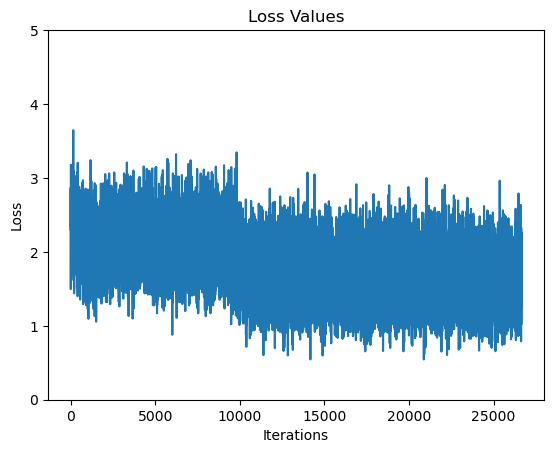

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_hist)

# Set the title and labels for the plot
ax.set_title('Loss Values')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_ylim([0, 5])

# Show the plot
plt.show()
fig.savefig('loss_values.pdf')

In [68]:
torch.save(nnet.state_dict(), 'nnet7.pth')

In [70]:
from itertools import product

# Generate all possible configurations
possible_configs = product([-1, 0, 1], repeat=9)

# Filter out the ones where the number of 1's is greater than the number of -1's
configs = []
for config in possible_configs:
    config_array = np.array(config).reshape(3, 3)
    if (((config_array == 1).sum() <= (config_array == -1).sum()) and  (abs((config_array == -1).sum() - (config_array == 1).sum()) <= 1)) and (config_array == 0).sum() >= 1:
        configs.append(config_array)

In [72]:
filter = []
for config in configs:
    config_array = np.array(config).reshape(3, 3)
    if (config_array == 1).sum() <= (config_array == -1).sum():
        row_check = any((config_array == row).all() for row in [-1, 0, 1])
        col_check = any((config_array == col).all(axis=0).all() for col in [-1, 0, 1])
        diag_check = any((config_array == diag).all() for diag in [[-1, 0, 1], [1, 0, -1]])

        if not (row_check or col_check or diag_check):
            filter.append(config_array)

In [73]:
len(filter)

5917

In [74]:
# testing validity of actions of the 5000 random board configurations generated

In [75]:
@torch.no_grad()
def test_for_valids(arr):
    string = print_board(np.array(arr))
    emb = generate_embedding(prompt, string).to(device)
    pi, v = nnet(emb)
    actions = torch.argmax(torch.exp(pi), dim=-1)
    bat1 = np.array(arr).reshape((20,9))
    inds = actions
    bat = bat1[range(20), inds.detach().cpu().numpy()]
    return sum(abs(bat))

In [76]:
ctr = 0
for i in tqdm(range(250)):
    ctr += test_for_valids(filter[i*20: (i+1)*20])

100%|██████████| 250/250 [02:58<00:00,  1.40it/s]


In [ ]:
#number of total invalid moves in all 5,000 configurations tested

In [77]:
ctr

286

In [78]:
@torch.no_grad()
def test_for_valids_random(arr):
    inds = np.random.randint(0, 9, size=20)
    bat1 = np.array(arr).reshape((20,9))
    bat = bat1[range(20), inds]
    return sum(abs(bat))

In [79]:
# using probability of that randomly guessing will be correct to roughly estimate number of total invalid moves in all 5,000 configurations tested under random guessing
# what is the invalid actions frequency for a random agent?

In [80]:
ctr2 = 0
for i in tqdm(range(250)):
    ctr2 += test_for_valids_random(filter[i*20: (i+1)*20])
ctr2

100%|██████████| 250/250 [00:00<00:00, 28538.89it/s]


3158

In [ ]:
# testing performance

In [81]:
import logging

from tqdm import tqdm

log = logging.getLogger(__name__)


class Arena():
    """
    An Arena class where any 2 agents can be pit against each other.
    """

    def __init__(self, player1, player2, game, display=None):
        """
        Input:
            player 1,2: two functions that takes board as input, return action
            game: Game object
            display: a function that takes board as input and prints it (e.g.
                     display in othello/OthelloGame). Is necessary for verbose
                     mode.

        see othello/OthelloPlayers.py for an example. See pit.py for pitting
        human players/other baselines with each other.
        """
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.display = display

    def playGame(self, verbose=False):
        """
        Executes one episode of a game.

        Returns:
            either
                winner: player who won the game (1 if player1, -1 if player2)
            or
                draw result returned from the game that is neither 1, -1, nor 0.
        """
        players = [self.player2, None, self.player1]
        curPlayer = 1
        board = self.game.getInitBoard()
        it = 0
        while self.game.getGameEnded(board, curPlayer) == 0:
            it += 1
            if verbose:
                assert self.display
                print("Turn ", str(it), "Player ", str(curPlayer))
                self.display(board)
            action = players[curPlayer + 1](self.game.getCanonicalForm(board, curPlayer))

            valids = self.game.getValidMoves(self.game.getCanonicalForm(board, curPlayer), 1)

            if valids[action] == 0:
                log.error(f'Action {action} is not valid!')
                log.debug(f'valids = {valids}')
                assert valids[action] > 0
            board, curPlayer = self.game.getNextState(board, curPlayer, action)
        if verbose:
            assert self.display
            print("Game over: Turn ", str(it), "Result ", str(self.game.getGameEnded(board, 1)))
            self.display(board)
        return curPlayer * self.game.getGameEnded(board, curPlayer)

    def playGames(self, num, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.

        Returns:
            oneWon: games won by player1
            twoWon: games won by player2
            draws:  games won by nobody
        """

        num = int(num / 2)
        oneWon = 0
        twoWon = 0
        draws = 0
        for _ in tqdm(range(num), desc="Arena.playGames (1)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == 1:
                oneWon += 1
            elif gameResult == -1:
                twoWon += 1
            else:
                draws += 1
        print(oneWon, twoWon, draws)

        self.player1, self.player2 = self.player2, self.player1

        for _ in tqdm(range(num), desc="Arena.playGames (2)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == -1:
                oneWon += 1
            elif gameResult == 1:
                twoWon += 1
            else:
                draws += 1

        return oneWon, twoWon, draws

In [82]:
class RandomPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        a = np.random.randint(self.game.getActionSize())
        valids = self.game.getValidMoves(board, 1)
        while valids[a]!=1:
            a = np.random.randint(self.game.getActionSize())
        return a

In [83]:
class Netplayer():
    def __init__(self, game):
        self.game = game
        self.invalid = 0
    def play(self, board):
        with torch.no_grad():
            boardtsr = torch.FloatTensor(board.astype(np.float64)).to(device)
            string = print_board(boardtsr)
            emb = generate_embedding(prompt, string).to(device)
            out_pi, _ = nnet(emb)
            _, actions = torch.topk(torch.exp(out_pi), 9, dim = -1)
            actions = actions.detach().cpu()[0]
            valids = self.game.getValidMoves(board, 1)
            ctr = 0
            # print(actions)
            while valids[actions[ctr]] == 0:
                self.invalid += 1
                ctr += 1
            return actions[ctr]
    def query(self):
        return self.invalid
                

In [84]:
net = Netplayer(g)

In [85]:
g = Game(3)
rp = RandomPlayer(g).play

In [86]:
arena = Arena(net.play, rp, g)

In [88]:
# trained auxillary network + LLaMA embedding playing against a random agent
arena.playGames(2000)

Arena.playGames (1): 100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]


937 22 41


Arena.playGames (2): 100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


(1535, 234, 231)

In [89]:
# Testing random board configurations
boards_test = np.array([np.array([[1, 0, 1],[-1,0,-1],[0,0,0]]), np.array([[1,0,1],[0,-1,0],[-1,0,0]]), np.array([[-1, -1,1],[-1,0,0],[1,0,1]]), np.array([[-1,-1,0],[0,0,1],[1,0,0]]),np.array([[1,-1,0],[1,0,1],[0,0,-1]]),np.array([[1,-1,0],[1,0,0],[0,0,-1]]),np.array([[-1,1,0],[0,1,0],[0,0,-1]]),np.array([[1,-1,0],[0,1,-1],[0,0,0]]),np.array([[0,-1,1],[0,1,0],[0,0,-1]])])

In [90]:
with torch.no_grad():
    nnet.eval()
    boardstr = print_board(boards_test) # (batchsize, )
    # print(boardstr,"nst")
    # print(np.shape(boardstr))
    emb = generate_embedding(prompt, boardstr).to(device)
    out_pi, _ = nnet(emb)
    print(torch.exp(out_pi))

tensor([[3.4635e-09, 2.3983e-01, 1.5828e-01, 1.6069e-03, 2.7979e-02, 2.3128e-02,
         3.0533e-01, 3.4339e-02, 2.0950e-01, 2.8687e-14],
        [3.2397e-03, 2.9815e-01, 1.0262e-02, 1.8115e-01, 7.3711e-03, 8.2058e-02,
         4.9930e-03, 4.9410e-02, 3.6337e-01, 3.8289e-09],
        [4.0914e-11, 2.6209e-04, 1.3396e-07, 3.7654e-04, 6.9575e-01, 1.2105e-01,
         6.7576e-05, 1.8235e-01, 1.4910e-04, 3.6910e-16],
        [9.7960e-07, 6.3140e-03, 1.9579e-01, 2.0310e-01, 6.8619e-02, 7.2571e-03,
         7.2616e-04, 1.4672e-01, 3.7147e-01, 1.2035e-12],
        [2.8313e-09, 1.2575e-04, 1.0579e-01, 1.0516e-02, 1.3224e-02, 8.4282e-02,
         2.3371e-01, 5.4828e-01, 4.0775e-03, 4.7840e-13],
        [5.0209e-09, 3.3650e-04, 1.4054e-01, 1.7337e-02, 1.1921e-01, 5.9871e-02,
         3.1278e-01, 3.4927e-01, 6.6568e-04, 7.7948e-13],
        [1.7981e-06, 2.9461e-03, 1.9103e-01, 4.8758e-02, 2.1890e-02, 1.3999e-01,
         3.1213e-01, 2.8201e-01, 1.2392e-03, 3.6600e-11],
        [2.8114e-06, 1.5785